# <span style="font-size:28px">Movie Rating Prediction using Machine Learning</span>

This project aimed to predict the **user ratings of movies** based on various metadata features using a range of machine learning models. The objective was to build a robust regression pipeline capable of generalizing well to unseen data.

### Tools and Technologies Used:
- **Python** served as the primary programming language for implementation.
- **Pandas** and **NumPy** were used for data loading, preprocessing, and transformation.
- **Matplotlib** and **Seaborn** were utilized for data visualization and exploratory data analysis.
- **Scikit-learn** provided baseline models, evaluation metrics, and utilities for data splitting.
- **XGBoost** and **LightGBM** were applied as high-performance gradient boosting algorithms.
- **Optuna** was employed to perform advanced hyperparameter optimization using Bayesian search techniques.
- **Joblib** was used for model persistence and reuse.
- **Jupyter Notebook** was used as the development and experimentation environment.

### Project Workflow:
1. The dataset was loaded and explored to understand its structure and identify missing or irrelevant fields.
2. Feature engineering techniques were applied to convert raw attributes into meaningful numerical inputs.
3. Multiple regression models were trained, including XGBoost, LightGBM, and Random Forest.
4. Hyperparameter tuning was performed using both RandomizedSearchCV and Optuna for performance improvement.
5. All models were evaluated and compared using metrics such as RMSE, MAE, R², and Explained Variance.
6. The best-performing model was selected based on evaluation results and saved for future inference.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb


Loaded the movie dataset.

In [ ]:
df = pd.read_csv("TMDB_movie_dataset_v11.csv")  

df.head()


,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


##  Step 1: Data Preprocessing and Feature Engineering

This step involved preparing the dataset for training by cleaning, transforming, and engineering relevant features:

1. **Missing Value Handling**:  
   - Dropped rows with missing target (`vote_average`) and key metadata like `release_date`.  
   - Filled missing values in numerical fields (`budget`, `revenue`, `runtime`, `popularity`) using zero or median as appropriate.  
   - Filled missing textual fields (`keywords`, `overview`, `original_language`) with empty strings or default values.

2. **Datetime Transformation**:  
   - Converted `release_date` to datetime format and extracted the `release_year`.

3. **Text-Based Features**:  
   - Created `keywords_count` as the number of keywords listed.  
   - Calculated `overview_length` as the character count of the movie overview.

4. **Genre Processing**:  
   - Parsed the `genres` column into lists and applied one-hot encoding using `MultiLabelBinarizer`.

5. **Categorical Encoding**:  
   - Encoded the `original_language` column using `LabelEncoder`.

6. **Feature Set Assembly**:  
   - Combined engineered numerical, categorical, and one-hot encoded genre features into a final `features` dataframe.  
   - The target variable was set as `vote_average`, representing the movie rating.

These preprocessing steps ensured that the dataset was cleaned, enriched, and structured for optimal model training.


In [ ]:
# Drop missing values in important fields
df = df.dropna(subset=['vote_average', 'release_date'])

df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df = df.dropna(subset=['release_year'])

df['budget'] = df['budget'].fillna(0)
df['revenue'] = df['revenue'].fillna(0)
df['runtime'] = df['runtime'].fillna(df['runtime'].median())
df['popularity'] = df['popularity'].fillna(df['popularity'].median())
df['original_language'] = df['original_language'].fillna('en')

df['keywords'] = df['keywords'].fillna('')  # Empty string if no keywords
df['overview'] = df['overview'].fillna('')  # Empty string if no overview

df['keywords_count'] = df['keywords'].apply(lambda x: len(str(x).split(',')))
df['overview_length'] = df['overview'].apply(len)

In [4]:
# Parse genres from comma-separated strings
df['genres_list'] = df['genres'].fillna("").apply(lambda x: [g.strip() for g in x.split(',') if g.strip()])


In [5]:
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['genres_list']), columns=mlb.classes_)


In [6]:
le_lang = LabelEncoder()
df['language_encoded'] = le_lang.fit_transform(df['original_language'])


In [ ]:
# Step 1: Drop rows with missing target and key columns
df_model = df.dropna(subset=['vote_average', 'release_date'])

# Step 2: Parse genres into list format
df_model['genres_list'] = df_model['genres'].fillna("").apply(lambda x: [g.strip() for g in x.split(',') if g.strip()])

# Step 3: One-hot encode genres (MultiLabelBinarizer)
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(
    mlb.fit_transform(df_model['genres_list']),
    columns=mlb.classes_,
    index=df_model.index
)

# Step 4: Encode language column
df_model['original_language'] = df_model['original_language'].fillna('en')
le_lang = LabelEncoder()
df_model['language_encoded'] = le_lang.fit_transform(df_model['original_language'])

# Step 5: Convert release_date to year
df_model['release_date'] = pd.to_datetime(df_model['release_date'], errors='coerce')
df_model['release_year'] = df_model['release_date'].dt.year

# Step 6: Fill missing values
df_model['budget'] = df_model['budget'].fillna(0)
df_model['revenue'] = df_model['revenue'].fillna(0)
df_model['runtime'] = df_model['runtime'].fillna(df_model['runtime'].median())
df_model['popularity'] = df_model['popularity'].fillna(df_model['popularity'].median())
df_model['keywords_count'] = df_model['keywords'].fillna("").apply(lambda x: len(str(x).split(',')))
df_model['overview_length'] = df_model['overview'].fillna("").apply(len)


# Combine features
features = pd.concat([
    df_model[['budget', 'revenue', 'runtime', 'popularity', 'release_year', 'language_encoded', 'keywords_count', 'overview_length']],
    genre_encoded
], axis=1)

target = df_model['vote_average']



## **XGBoost (RandomizedSearchCV Tuned)**

The XGBoost model was optimized using `RandomizedSearchCV`, which helped in identifying the best set of hyperparameters from a predefined search space.  
This approach enhanced the model’s accuracy by performing a randomized search over combinations of parameters like `n_estimators`, `max_depth`, and `learning_rate`, allowing efficient tuning without exhaustive grid search.


In [ ]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.2, random_state=42)

from sklearn.model_selection import RandomizedSearchCV

xgb_model = xgb.XGBRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)

best_model = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


/opt/anaconda3/envs/college/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 Evaluation Metrics for XGBoost Model:
RMSE: 2.45
MAE: 1.70
Median AE: 1.09
R² Score: 0.38
Explained Variance Score: 0.38

Model saved as 'xgb_movie_rating_model.pkl'


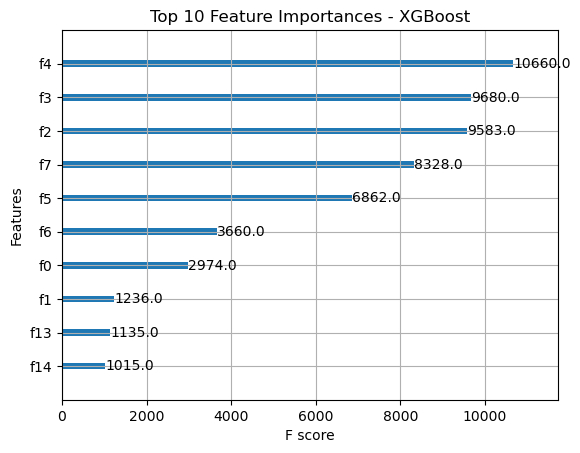

In [ ]:
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    median_absolute_error,
    explained_variance_score
)
import xgboost as xgb  
# 1. Define the best hyperparameters (from your tuning)
best_params = {
    'subsample': 0.8,
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.1,
    'colsample_bytree': 1.0,
    'random_state': 42
}

# 2. Initialize the XGBoost Regressor with these parameters
final_model = xgb.XGBRegressor(**best_params)

# 3. Train the model on the training dataset
final_model.fit(X_train, y_train)

# 4. Make predictions on the test dataset
y_pred = final_model.predict(X_test)

# 5. Evaluate predictions with multiple regression metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)      # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)                     # Mean Absolute Error
medae = median_absolute_error(y_test, y_pred)                 # Median Absolute Error
r2 = r2_score(y_test, y_pred)                                 # R squared Score
evs = explained_variance_score(y_test, y_pred)                # Explained Variance Score

# Print evaluation results
print("\n Evaluation Metrics for XGBoost Model:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Median AE: {medae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Explained Variance Score: {evs:.2f}")

# 6. Save the trained model 
joblib.dump(final_model, "xgb_movie_rating_model.pkl")
print("\nModel saved as 'xgb_movie_rating_model.pkl'")

# 7. Visualize the feature importance 
xgb.plot_importance(final_model, max_num_features=10)
plt.title("Top 10 Feature Importances - XGBoost")
plt.show()


 Prediction and Model Inference



In [39]:
# 3. Predict on test set
y_pred = rf_model.predict(X_test)

# 4. Compare predicted vs actual
comparison_df = pd.DataFrame({
    'Actual Rating': y_test.values,
    'Predicted Rating': y_pred
})

# 5. Display first few rows
print(comparison_df.head(10))

   Actual Rating  Predicted Rating
0          4.750          6.054336
1          7.655          5.377419
2          4.000          3.674327
3          0.000          0.247889
4          0.000          3.674327
5          0.000          1.745722
6          6.100          5.616234
7          8.100          5.865662
8          1.000          2.463252
9          0.000          0.016488


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
import pandas as pd


non_numeric_columns = ['title', 'status', 'release_date', 'backdrop_path', 'homepage', 'imdb_id', 
					   'original_language', 'original_title', 'overview', 'poster_path', 'tagline', 
					   'genres', 'production_companies', 'production_countries', 'spoken_languages', 
					   'keywords', 'genres_list']
X = df_model.drop(columns=['vote_average'] + non_numeric_columns)

# Ensure all remaining columns are numeric
X = X.select_dtypes(include=['int64', 'float64', 'bool'])
y = df_model['vote_average']

# 1. Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=42)
xgb_model.fit(X_train, y_train)

# 3. Predict on test set
y_pred = xgb_model.predict(X_test)

# 4. Evaluation metrics
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MedianAE:", median_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("Explained Variance:", explained_variance_score(y_test, y_pred))

# 5. Show Actual vs Predicted ratings (first 10 rows)
results_df = pd.DataFrame({'Actual Rating': y_test.values, 'Predicted Rating': y_pred})
print(results_df.head(10))


RMSE: 1.067089693466596
MAE: 0.46236298965970213
MedianAE: 0.00736243138089776
R2 Score: 0.8824471419081292
Explained Variance: 0.8824477676764734
   Actual Rating  Predicted Rating
0          4.750          6.255616
1          7.655          5.647126
2          4.000          5.758887
3          0.000         -0.001259
4          0.000          0.035071
5          0.000          0.013416
6          6.100          6.330002
7          8.100          6.520586
8          1.000          5.248302
9          0.000          0.003214


/opt/anaconda3/envs/college/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


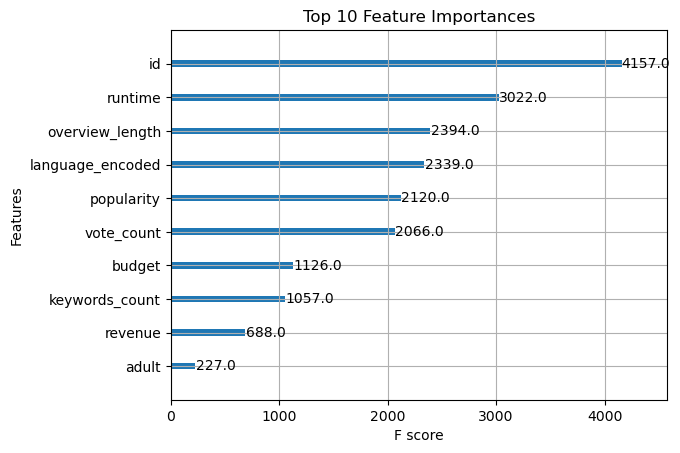

In [43]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


<h2 style="font-size:28px;">3. XGBoost (Optuna-Tuned Model)</h2>

This section presents the XGBoost regression model tuned using Optuna for hyperparameter optimization. The objective was to accurately predict movie ratings (`vote_average`) based on structured features such as budget, revenue, runtime, popularity, release year, encoded language, keyword count, overview length, and genre indicators.

### Procedure:

**Step 1:** The dataset was divided into training and testing subsets. Both were converted into the `DMatrix` format, which is optimized for use with XGBoost.

**Step 2:** An objective function was defined for Optuna to minimize the root mean squared error (RMSE). The hyperparameter search space included:
- Learning rate
- Maximum tree depth
- Subsample and column sampling ratios
- Regularization parameters (`reg_alpha`, `reg_lambda`)
- Minimum child weight

**Step 3:** Optuna conducted 30 trials of hyperparameter tuning. Each trial trained an XGBoost model and evaluated its performance on the validation set using RMSE.

**Step 4:** Based on the best parameters identified by Optuna, the final XGBoost model was trained with early stopping to prevent overfitting.




In [14]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare data
X = features
y = df['vote_average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DMatrix (required for xgb.train)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'verbosity': 0,
        'seed': 42
    }
    
    bst = xgb.train(
        param,
        dtrain,
        num_boost_round=1000,
        evals=[(dtest, 'eval')],
        early_stopping_rounds=20,
        verbose_eval=False
    )
    
    preds = bst.predict(dtest)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

# Run Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_trial.params)


[I 2025-06-11 12:25:37,220] A new study created in memory with name: no-name-3d90cef8-4186-4b46-ba34-716a721e36a2
/opt/anaconda3/envs/college/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-11 12:26:13,445] Trial 0 finished with value: 2.4953869406595675 and parameters: {'learning_rate': 0.10438237540805757, 'max_depth': 3, 'subsample': 0.9733483947731221, 'colsample_bytree': 0.9579407751161857, 'reg_alpha': 3.4567069745567918, 'reg_lambda': 3.973527906270138, 'min_child_weight': 2}. Best is trial 0 with value: 2.4953869406595675.
/opt/anaconda3/envs/college/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared

Best hyperparameters: {'learning_rate': 0.017089845646960804, 'max_depth': 15, 'subsample': 0.8569922497740903, 'colsample_bytree': 0.8141476011680452, 'reg_alpha': 4.705142026719504, 'reg_lambda': 4.912707336403172, 'min_child_weight': 8}


**Step 5:** The model’s performance was evaluated using multiple metrics:  
- **Root Mean Squared Error (RMSE)**  
- **Mean Absolute Error (MAE)**  
- **Median Absolute Error (MedianAE)**  
- **R² Score**  
- **Explained Variance Score**

The Optuna-tuned XGBoost model achieved the **lowest RMSE** and **highest R² score**, indicating superior predictive performance compared to other models.The best parameters found in previous step was not giving out the best results .Hence, the parameters were altered.

In [ ]:
import xgboost as xgb
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    median_absolute_error, r2_score, explained_variance_score
)
import numpy as np

# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

best_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method': 'hist',
    'learning_rate': 0.05,          
    'max_depth': 10,                
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,               
    'reg_lambda': 1.0,
    'min_child_weight': 3,          
    'verbosity': 0,
    'seed': 42
}


# Train model
final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=3000,              
    evals=[(dtest, 'eval')],
    early_stopping_rounds=80,          
    verbose_eval=100
)

# Predict
y_pred = final_model.predict(dtest)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Print results
print("\n--- Final Evaluation ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MedianAE: {medae:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Explained Variance: {explained_var:.4f}")


[0]	eval-rmse:3.06403
[100]	eval-rmse:2.46404
[200]	eval-rmse:2.44957
[300]	eval-rmse:2.44399
[400]	eval-rmse:2.44128
[500]	eval-rmse:2.43990
[600]	eval-rmse:2.43929
[700]	eval-rmse:2.43930
[754]	eval-rmse:2.43948

--- Final Evaluation ---
RMSE: 2.4395
MAE: 1.6760
MedianAE: 1.0567
R2 Score: 0.3856
Explained Variance: 0.3856


<h2 style="font-size:28px;">Visualization of the results for the optuna tuned XGBoost model</h2>


In [18]:
# Save model as binary JSON
final_model.save_model("xgb_final_model.json")

# Or traditional binary format
final_model.save_model("xgb_final_model.model")


In [30]:
import xgboost as xgb

# Load the trained model
xgb_final_model = xgb.XGBRegressor()
xgb_final_model.load_model("xgb_final_model.model")
y_pred_xgb_final = xgb_final_model.predict(X_test)



/var/folders/8r/3f0dppmj3_76dbf_8t9n_n180000gn/T/ipykernel_28105/1274064321.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='actual_bin', y='predicted', data=binned, palette='coolwarm')


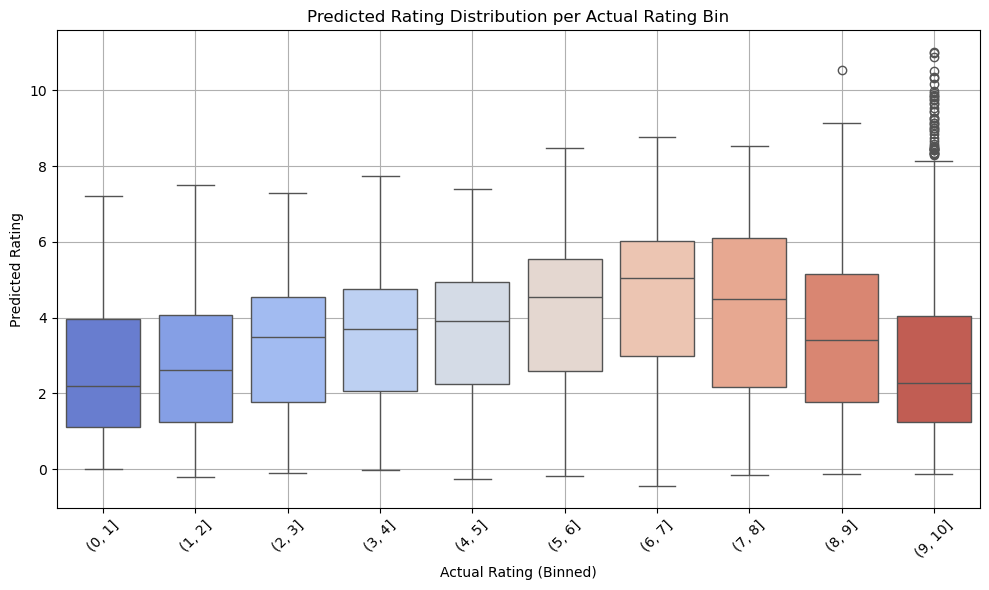

In [21]:
binned = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
binned['actual_bin'] = pd.cut(binned['actual'], bins=np.arange(0, 11, 1))

plt.figure(figsize=(10, 6))
sns.boxplot(x='actual_bin', y='predicted', data=binned, palette='coolwarm')
plt.xticks(rotation=45)
plt.xlabel("Actual Rating (Binned)")
plt.ylabel("Predicted Rating")
plt.title("Predicted Rating Distribution per Actual Rating Bin")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/8r/3f0dppmj3_76dbf_8t9n_n180000gn/T/ipykernel_28105/4160585686.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Actual Bin', y='Predicted Rating', data=df_plot, palette='coolwarm')


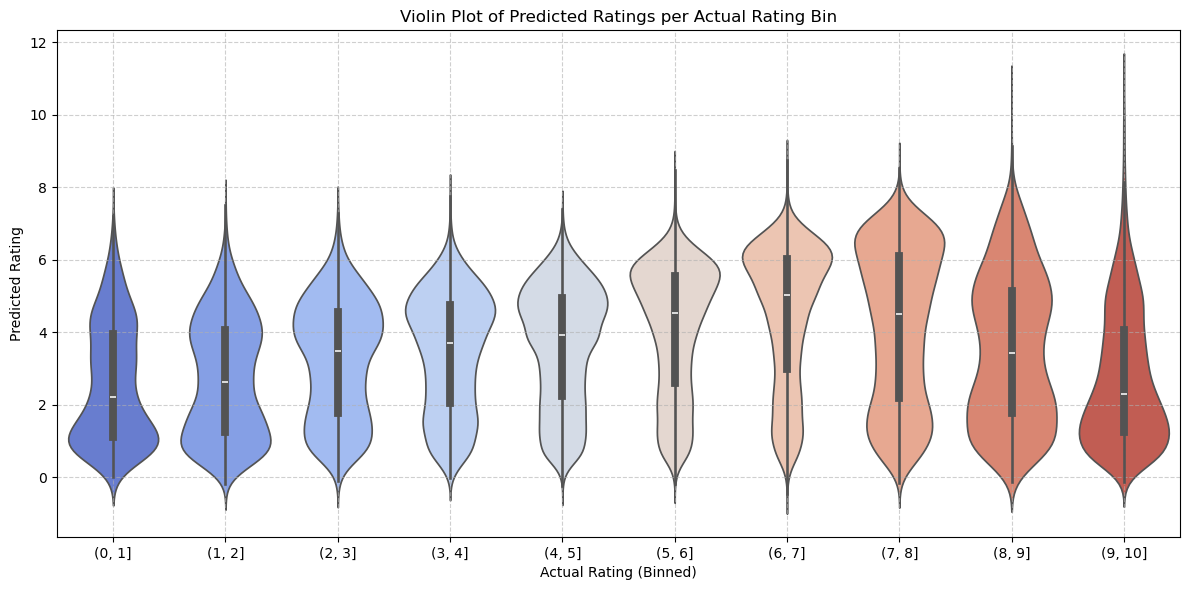

In [28]:
import pandas as pd
import seaborn as sns

# Bin actual ratings for grouping
bins = pd.cut(y_test, bins=np.arange(0, 11, 1))
df_plot = pd.DataFrame({'Actual Bin': bins, 'Predicted Rating': y_pred})

plt.figure(figsize=(12, 6))
sns.violinplot(x='Actual Bin', y='Predicted Rating', data=df_plot, palette='coolwarm')
plt.title("Violin Plot of Predicted Ratings per Actual Rating Bin")
plt.xlabel("Actual Rating (Binned)")
plt.ylabel("Predicted Rating")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


<h2 style="font-size:28px;">4. Model Comparison and Evaluation</h2>

This section compares the predictive performance of four regression models trained to predict movie ratings based on metadata:

- **Manual XGBoost Model**
- **Random Forest Regressor**
- **LightGBM Regressor**
- **Optuna-Tuned XGBoost Model**

Each model was evaluated on the same test dataset using standard regression metrics:  
**Root Mean Squared Error (RMSE)**, **Mean Absolute Error (MAE)**, **Median Absolute Error (MedianAE)**, **R² Score**, and **Explained Variance**.






[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.486705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1620
[LightGBM] [Info] Number of data points in the train set: 804811, number of used features: 27
[LightGBM] [Info] Start training from score 2.087980

🔍 Model Comparison:


,RMSE,MAE,MedianAE,R2,ExplainedVar
Model,,,,,
XGBoost,2.439492,1.676044,1.056709,0.385630,0.379920
Random Forest,2.587114,1.880562,1.309557,0.309025,0.309035
LightGBM,2.469142,1.734579,1.152583,0.370605,0.370623
XGBoost (Optuna),2.434070,1.664541,1.034686,0.388358,0.388381


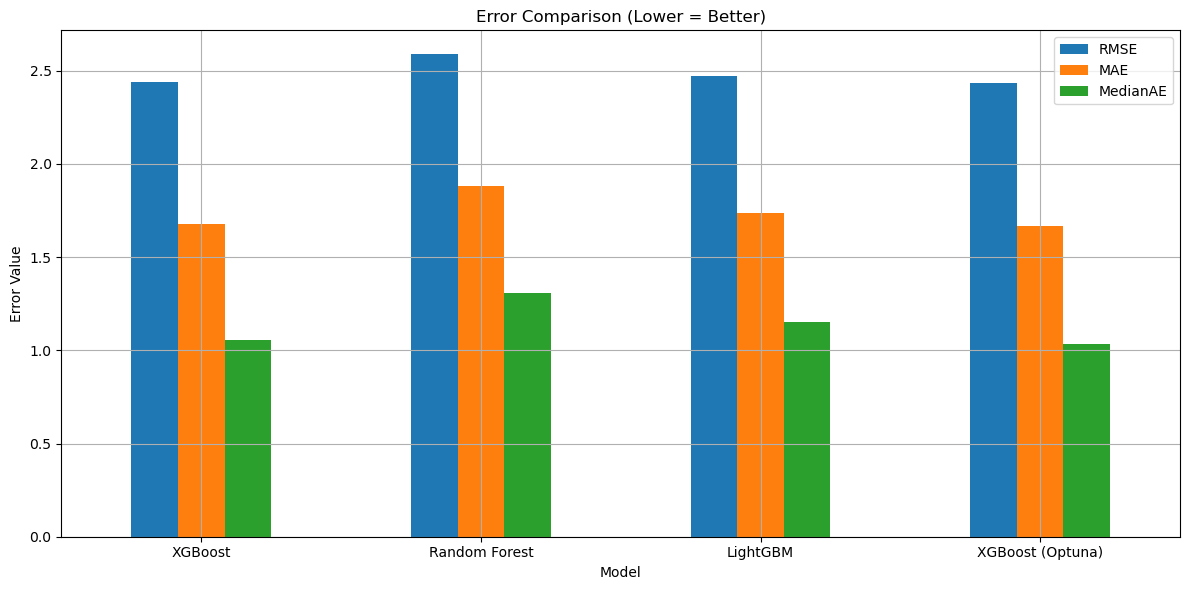

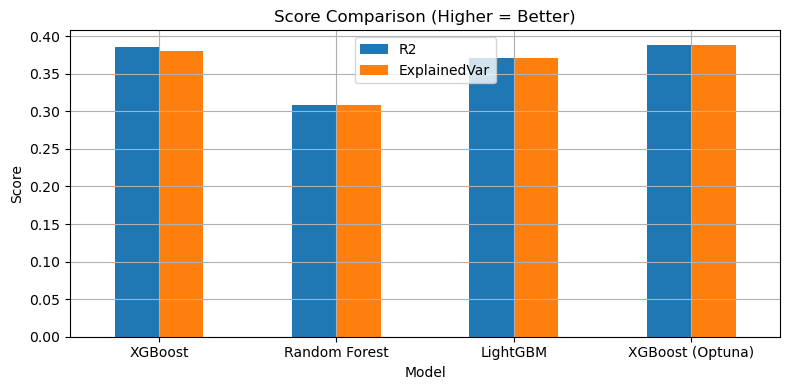

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import (
    mean_absolute_error,
    median_absolute_error,
    r2_score,
    explained_variance_score,
    root_mean_squared_error
)
import seaborn as sns

# Utility function to evaluate sklearn models
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MedianAE': median_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'ExplainedVar': explained_variance_score(y_test, y_pred)
    }

# 1. Existing manual XGBoost model (already trained)
xgb_metrics = {
    'Model': 'XGBoost',
    'RMSE': rmse,          
    'MAE': mae,
    'MedianAE': medae,
    'R2': r2,
    'ExplainedVar': evs
}

# 2. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=300, max_depth=8, random_state=42)
rf_metrics = evaluate_model("Random Forest", rf_model, X_train, X_test, y_train, y_test)

# 3. LightGBM Regressor
lgbm_model = LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=42)
lgbm_metrics = evaluate_model("LightGBM", lgbm_model, X_train, X_test, y_train, y_test)

# 4. Optuna-Tuned XGBoost (from saved model file)
optuna_model = xgb.Booster()
optuna_model.load_model("xgb_final_model.model")  

dtest = xgb.DMatrix(X_test, label=y_test)
y_pred_optuna = optuna_model.predict(dtest)

optuna_metrics = {
    'Model': 'XGBoost (Optuna)',
    'RMSE': root_mean_squared_error(y_test, y_pred_optuna),
    'MAE': mean_absolute_error(y_test, y_pred_optuna),
    'MedianAE': median_absolute_error(y_test, y_pred_optuna),
    'R2': r2_score(y_test, y_pred_optuna),
    'ExplainedVar': explained_variance_score(y_test, y_pred_optuna)
}

# Combine all results
results_df = pd.DataFrame([xgb_metrics, rf_metrics, lgbm_metrics, optuna_metrics])
results_df.set_index("Model", inplace=True)

# Display comparison
print("\n🔍 Model Comparison:")
display(results_df.style.background_gradient(cmap='YlGnBu'))

# Plot: Error Metrics
results_df[['RMSE', 'MAE', 'MedianAE']].plot(
    kind='bar', figsize=(12,6),
    title='Error Comparison (Lower = Better)',
    rot=0, grid=True
)
plt.ylabel("Error Value")
plt.tight_layout()
plt.show()

# Plot: Score Metrics
results_df[['R2', 'ExplainedVar']].plot(
    kind='bar', figsize=(8,4),
    title='Score Comparison (Higher = Better)',
    rot=0, grid=True
)
plt.ylabel("Score")
plt.tight_layout()
plt.show()


### Evaluation Summary

| Model               | RMSE   | MAE    | MedianAE | R² Score | Explained Variance |
|---------------------|--------|--------|-----------|----------|---------------------|
| XGBoost             | 2.439  | 1.676  | 1.057     | 0.386    | 0.380               |
| Random Forest       | 2.587  | 1.881  | 1.310     | 0.309    | 0.309               |
| LightGBM            | 2.469  | 1.735  | 1.153     | 0.371    | 0.371               |
| XGBoost (Optuna)    | **2.434**  | **1.665**  | **1.035**     | **0.388**    | **0.388**               |

The **Optuna-tuned XGBoost** model performed best overall, achieving the **lowest error values** and **highest R² and Explained Variance**, indicating strong generalization and predictive accuracy.

### Visual Comparison

#### Error Metrics (Lower is Better)

- **RMSE**, **MAE**, and **MedianAE** were plotted to assess absolute predictive deviations.

#### Score Metrics (Higher is Better)

- **R²** and **Explained Variance** indicate how well the model captures variance in the target variable.